In [272]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

### Преобразуем текст в векторы

In [273]:
def get_vectorizer(vectorizer, x_train, x_test):
    x_train = vectorizer.fit_transform(x_train)
    x_test = vectorizer.transform(x_test)

    return x_train, x_test

### Обучаем модель

In [274]:
def get_model(x_train, y_train, class_prior=None):
    model = MultinomialNB(class_prior=class_prior)
    model.fit(x_train, y_train)
    return model

### Получаем предсказания


In [275]:
def get_prediction(model, x_test):
    y_pred = model.predict(x_test)
    probability = model.predict_proba(x_test)
    return y_pred, probability


### Получаем отчет

In [276]:
def get_report(y_test, y_pred):
    print(classification_report(y_test, y_pred))


### Получаем ROC кривую


In [277]:
def get_roc_curve(y_test, probability):
    fpr, tpr, _ = roc_curve(y_test, probability[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

## Основная часть

In [278]:
def draw_roc(vectorizer, x_train, x_test, y_train, y_test):
    x_train_v, x_test_v = get_vectorizer(vectorizer, x_train, x_test)
    model = get_model(x_train_v, y_train)
    y_pred, probability = get_prediction(model, x_test_v)
    # get_report(y_test, y_pred)
    get_roc_curve(y_test, probability)

### Перебор class_prior

Перебираем `i`, такие что FP равно 0 и score - максимальный

In [279]:
def find_accuracy(vectorizer, x_train, x_test, y_train, y_test):
    result = []
    x_train_v, x_test_v = get_vectorizer(vectorizer, x_train, x_test)
    min_log = 0
    max_score = 0
    for i in range(300):
        eps = 10 ** (-i)
        model = get_model(x_train_v, y_train, class_prior=[1 - eps, eps])
        y_pred, probas = get_prediction(model, x_test_v)
        score = model.score(x_test_v, y_test)
        count_fpr = 0
        for j in range(len(y_pred)):
            if y_pred[j] == 1 and y_test.iloc[j] == 0:
                count_fpr += 1
        if count_fpr == 0:
            if score > max_score:
                min_log = -i
                max_score = score
            print("log(eps)= ", -i, ", score= ", score)
        result.append((-i, score, count_fpr))
    print(f"Лучшее распределение: [1 - {10 ** min_log}; {10 ** min_log}]")
    print(f"Score: {max_score}")
    return result


### Рисуем график зависимости

In [280]:
def draw_accuracy(result):
    fig, axs = plt.subplots(2)
    axs[0].set_ylabel('Accuracy')
    axs[0].plot([i[0] for i in result], [i[1] for i in result])
    axs[1].set_xlabel('log(eps)')
    axs[1].set_ylabel('False positive')
    axs[1].plot([i[0] for i in result], [i[2] for i in result])
    plt.show()


In [281]:
def run(X, Y):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.7)

    # Используем два способа векторизации
    draw_roc(CountVectorizer(), x_train, x_test, y_train, y_test)
    draw_roc(TfidfVectorizer(), x_train, x_test, y_train, y_test)

    # Находим лучшее распределение
    result = find_accuracy(CountVectorizer(), x_train, x_test, y_train, y_test)
    draw_accuracy(result)


### Чтение данных

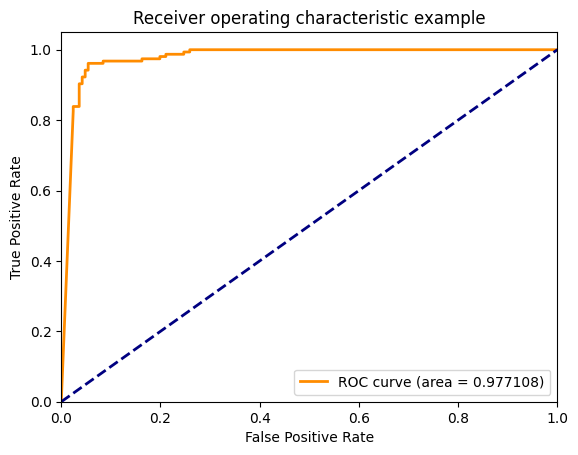

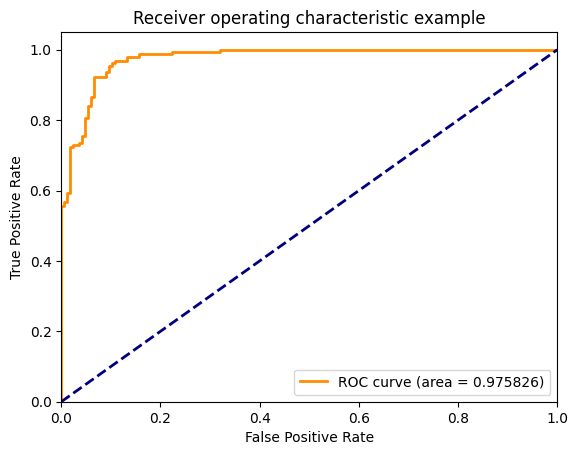

C:\Users\marse\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\naive_bayes.py:566: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = np.log(class_prior)


log(eps)=  -290 , score=  0.6043613707165109
log(eps)=  -291 , score=  0.6043613707165109
log(eps)=  -292 , score=  0.6043613707165109
log(eps)=  -293 , score=  0.6043613707165109
log(eps)=  -294 , score=  0.6043613707165109
log(eps)=  -295 , score=  0.6043613707165109
log(eps)=  -296 , score=  0.6043613707165109
log(eps)=  -297 , score=  0.6043613707165109
log(eps)=  -298 , score=  0.6043613707165109
log(eps)=  -299 , score=  0.6043613707165109
Лучшее распределение: [1 - 1e-290; 1e-290]
Score: 0.6043613707165109


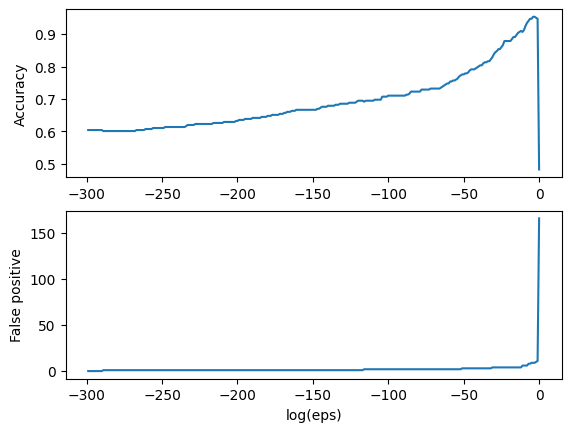

In [282]:
data = pd.read_csv('messages.csv')
run(data.subject + data.message, data.spam)
# run(data.message, data.spam)